<a href="https://colab.research.google.com/github/Shakil97/bangla-songs-lyrics-sentiment-analysis/blob/main/pyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==2.11.0

     |████████████████████████████████| 675kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 35.9MB/s 
     |████████████████████████████████| 5.6MB 49.4MB/s 
     |████████████████████████████████| 890kB 50.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=8011772a25179d4f6ed7f2d107c17997ac30bed2610327d636fdde3bbc1c7034
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
import pandas as pd
from google.colab import files

In [4]:
uploaded= files.upload()

Saving BanglaSongs - BanglaSongs.csv to BanglaSongs - BanglaSongs.csv


In [5]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "BanglaSongs - BanglaSongs.csv" with length 398279 bytes


In [6]:
uploaded

{'BanglaSongs - BanglaSongs.csv': b'title,category,lyrics,Mood\r\n\xe0\xa6\x85\xe0\xa6\xaa\xe0\xa6\xb0\xe0\xa6\xbe\xe0\xa6\x9c\xe0\xa6\xbf\xe0\xa6\xa4,\xe0\xa6\xac\xe0\xa7\x8d\xe0\xa6\xaf\xe0\xa6\xbe\xe0\xa6\xa8\xe0\xa7\x8d\xe0\xa6\xa1,"\xe0\xa6\x8f\xe0\xa6\xac\xe0\xa6\xbe\xe0\xa6\xb0 \xe0\xa6\xa4\xe0\xa7\x8b\xe0\xa6\xae\xe0\xa6\xbe\xe0\xa6\xb0 \xe0\xa6\x95\xe0\xa6\xa5\xe0\xa6\xbe\xe0\xa6\x97\xe0\xa7\x81\xe0\xa6\xb2\xe0\xa7\x8b\xe0\xa6\xb0\n\xe0\xa6\x95\xe0\xa6\xbe\xe0\xa6\x9b\xe0\xa7\x87 \xe0\xa6\x86\xe0\xa6\xae\xe0\xa6\xbf \xe0\xa6\x85\xe0\xa6\xaa\xe0\xa6\xb0\xe0\xa6\xbe\xe0\xa6\x9c\xe0\xa6\xbf\xe0\xa6\xa4\n\xe0\xa6\x9c\xe0\xa6\xae\xe0\xa7\x87 \xe0\xa6\xa5\xe0\xa6\xbe\xe0\xa6\x95\xe0\xa6\xbe \xe0\xa6\xaf\xe0\xa6\xa4 \xe0\xa6\x85\xe0\xa6\xa8\xe0\xa7\x81\xe0\xa6\xad\xe0\xa7\x82\xe0\xa6\xa4\xe0\xa6\xbf \xe0\xa6\x86\xe0\xa6\xae\xe0\xa6\xbe\xe0\xa6\xb0\n\xe0\xa6\x9c\xe0\xa6\xb2 \xe0\xa6\xb0\xe0\xa6\x99\xe0\xa7\x87 \xe0\xa6\xb9\xe0\xa6\xbe\xe0\xa6\xb0\xe0\xa6\xbf\xe0\xa7\x9f\xe0\xa7\x87 \x

In [7]:
import io

In [8]:
df= pd.read_csv(io.StringIO(uploaded['BanglaSongs - BanglaSongs.csv'].decode('utf-8')))
df.isnull().values.any()

df.shape

(251, 4)

In [9]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [10]:
import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
df.head()

,title,category,lyrics,Mood
0,অপরাজিত,ব্যান্ড,এবার তোমার কথাগুলোর\nকাছে আমি অপরাজিত\nজমে থাক...,বেদনা
1,আমার ভায়ের রক্তে রাঙানো,দেশাত্মবোধক গান,আমার ভায়ের রক্তে রাঙানো একুশে ফেব্রুয়ারি\nআমি ...,দেশপ্রেম
2,দয়াল চান্দের পায়ের দুলা আমি যেন হইতে পারি,বাউল,আমি কুকুর হইয়া দেই পাহাড়া\nদয়াল চান্দের ঘড় বাড়...,ধার্মিক
3,মাওলানা,বাউল,তুমি এসমে আজ যত তরানে ওলা\nগাউছেলাম বাবা নুরে ...,ধার্মিক
4,আমার আপনার চেয়ে আপন যে জন,নজরুল গীতি,আমার আপনার চেয়ে আপন যে জন\nখুঁজি তারে আমি আপন...,প্রেম


In [ ]:
df.category.value_counts()

ছায়াছবি            95
নজরুল গীতি         36
আধুনিক             32
রবীন্দ্র সংগীত     30
ব্যান্ড            15
বাউল               11
Uncategorized       7
পল্লীগীতি           4
জীবনমুখী গান        4
দেশাত্মবোধক গান     4
বিবিধ               3
ভাটিয়ালি            3
পপ সঙ্গীত           2
ছড়াগান              2
লালন                1
ভক্তিমূলক গান       1
ইসলামী গান          1
Name: category, dtype: int64

In [12]:
df.Mood.value_counts()

প্রেম       111
বেদনা        91
আনন্দ        23
ধার্মিক      14
দেশপ্রেম     12
Name: Mood, dtype: int64

In [13]:
possible_Moods = df.Mood.unique()

In [14]:
Mood_dict = {}
for index, possible_Moods in enumerate(possible_Moods):
    Mood_dict[possible_Moods] = index

In [15]:
df['label'] = df.Mood.replace(Mood_dict)

In [65]:
df.head(300)

,title,category,lyrics,Mood,label,mood
0,অপরাজিত,ব্যান্ড,এবার তোমার কথাগুলোর\nকাছে আমি অপরাজিত\nজমে থাক...,বেদনা,0,0
1,আমার ভায়ের রক্তে রাঙানো,দেশাত্মবোধক গান,আমার ভায়ের রক্তে রাঙানো একুশে ফেব্রুয়ারি\nআমি ...,দেশপ্রেম,1,1
2,দয়াল চান্দের পায়ের দুলা আমি যেন হইতে পারি,বাউল,আমি কুকুর হইয়া দেই পাহাড়া\nদয়াল চান্দের ঘড় বাড়...,ধার্মিক,2,2
3,মাওলানা,বাউল,তুমি এসমে আজ যত তরানে ওলা\nগাউছেলাম বাবা নুরে ...,ধার্মিক,2,2
4,আমার আপনার চেয়ে আপন যে জন,নজরুল গীতি,আমার আপনার চেয়ে আপন যে জন\nখুঁজি তারে আমি আপন...,প্রেম,3,3
...,...,...,...,...,...,...
246,এক মুঠো রোদ্দুর হাতে,আধুনিক,"এক মুঠো রোদ্দুর হাতে,\nএক আকাশ নীল\nআজ তোমার জ...",প্রেম,3,3
247,জোনাকি গায় ফিসফিস,আধুনিক,"জোনাকি গায় ফিসফিস,\nহাওয়া দিয়ে যায় শিষ,\nতাতে ...",বেদনা,0,0
248,এলো বসন্ত ডাকে পাখি,আধুনিক,"এলো বসন্ত ডাকে পাখি,\nকি করে মনটা বেধে রাখি,\n...",প্রেম,3,3
249,মনে মনে সে জানিনা আজ কি ভেবে নিয়েছে,আধুনিক,মনে মনে সে জানিনা আজ কি ভেবে নিয়েছে?\nআমি গোলা...,প্রেম,3,3


In [17]:
df.shape

(251, 5)

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     251 non-null    object
 1   category  251 non-null    object
 2   lyrics    251 non-null    object
 3   Mood      251 non-null    object
 4   label     251 non-null    int64 
 5   mood      251 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 11.9+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


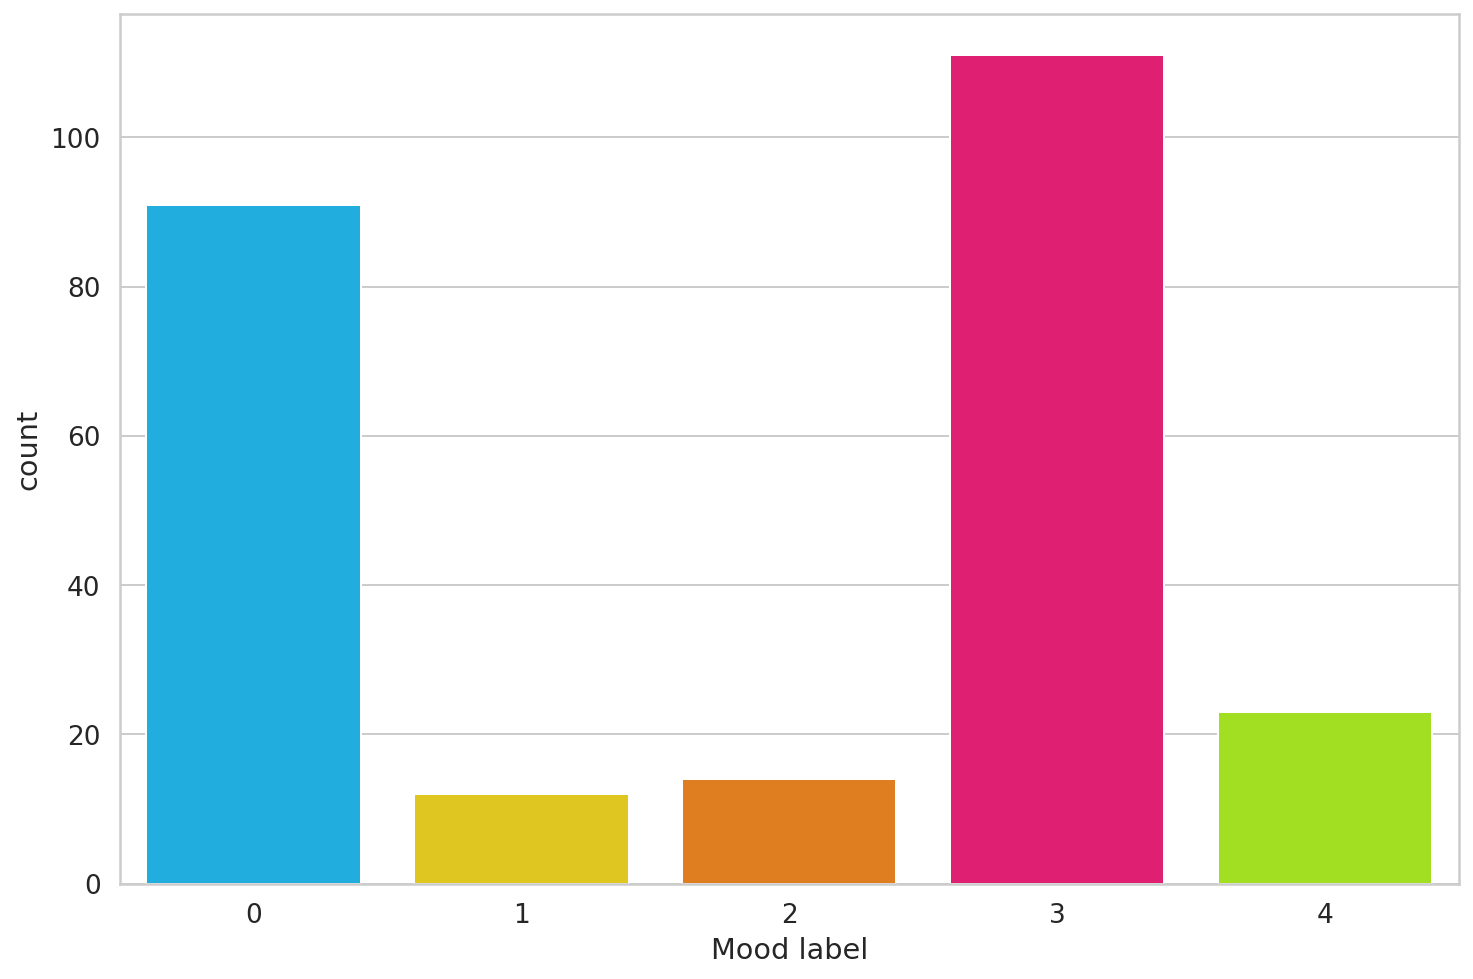

In [ ]:
sns.countplot(df.label)
plt.xlabel('Mood label');

In [18]:
def to_mood(rating):
  rating = int(rating)
  if rating == 0:
    return 0
  elif rating == 1:
    return 1
  elif rating == 2:
    return 2
  elif rating == 3:
    return 3    
  else: 
    return 4

df['mood'] = df.label.apply(to_mood)

In [19]:
class_names = ['বেদনা', 'দেশপ্রেম	', 'ধার্মিক', 'প্রেম', 'আনন্দ']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/u

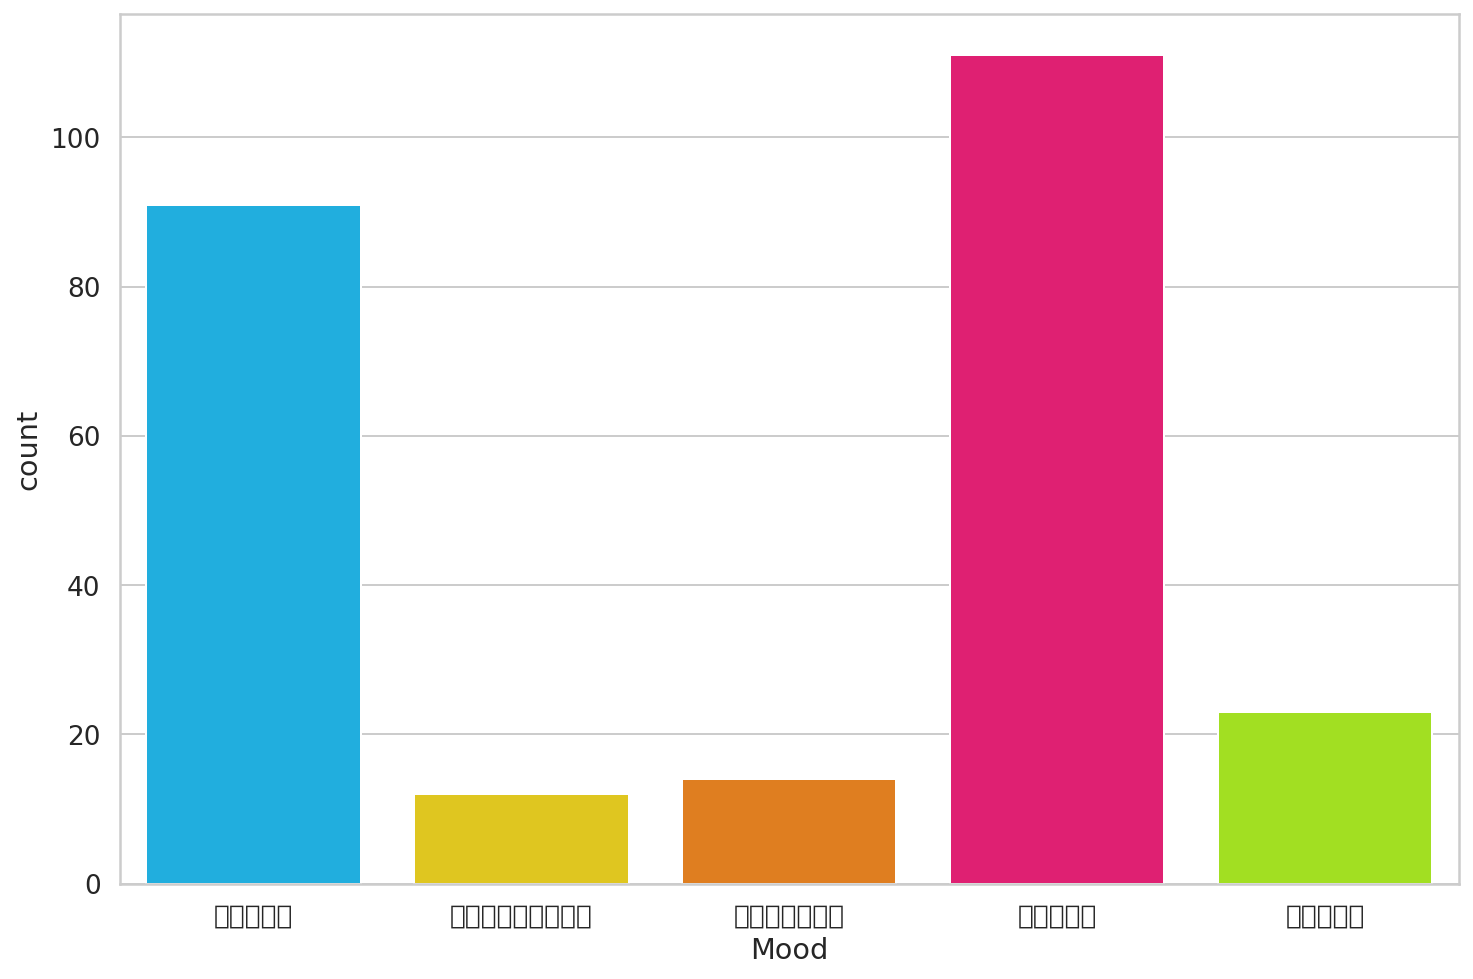

In [ ]:
ax = sns.countplot(df.mood)
plt.xlabel('Mood')
ax.set_xticklabels(class_names);

In [20]:
PRE_TRAINED_MODEL_NAME = 'sagorsarker/bangla-bert-base'

In [21]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [22]:
sample_txt = 'আমার বেলা যে যায় সাঁঝ-বেলাতে তোমার সুরে সুরে সুর মেলাতে'

In [23]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: আমার বেলা যে যায় সাঁঝ-বেলাতে তোমার সুরে সুরে সুর মেলাতে
   Tokens: ['আমার', 'বেলা', 'যে', 'যা', '##য', 'সা', '##ঝ', '-', 'বেলা', '##তে', 'তে', '##ামা', '##র', 'সরে', 'সরে', 'সর', 'মেলাতে']
Token IDs: [2211, 2918, 2060, 2120, 9294, 3671, 18679, 1012, 2918, 2200, 4058, 40677, 2046, 3956, 3956, 15803, 15686]


In [24]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [25]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [26]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [27]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [28]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [29]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2211,  2918,  2060,  2120,  9294,  3671, 18679,  1012,  2918,
         2200,  4058, 40677,  2046,  3956,  3956, 15803, 15686,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [30]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [31]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'আমার',
 'বেলা',
 'যে',
 'যা',
 '##য',
 'সা',
 '##ঝ',
 '-',
 'বেলা',
 '##তে',
 'তে',
 '##ামা',
 '##র',
 'সরে',
 'সরে',
 'সর',
 'মেলাতে',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [32]:
token_lens = []

for txt in df.lyrics:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


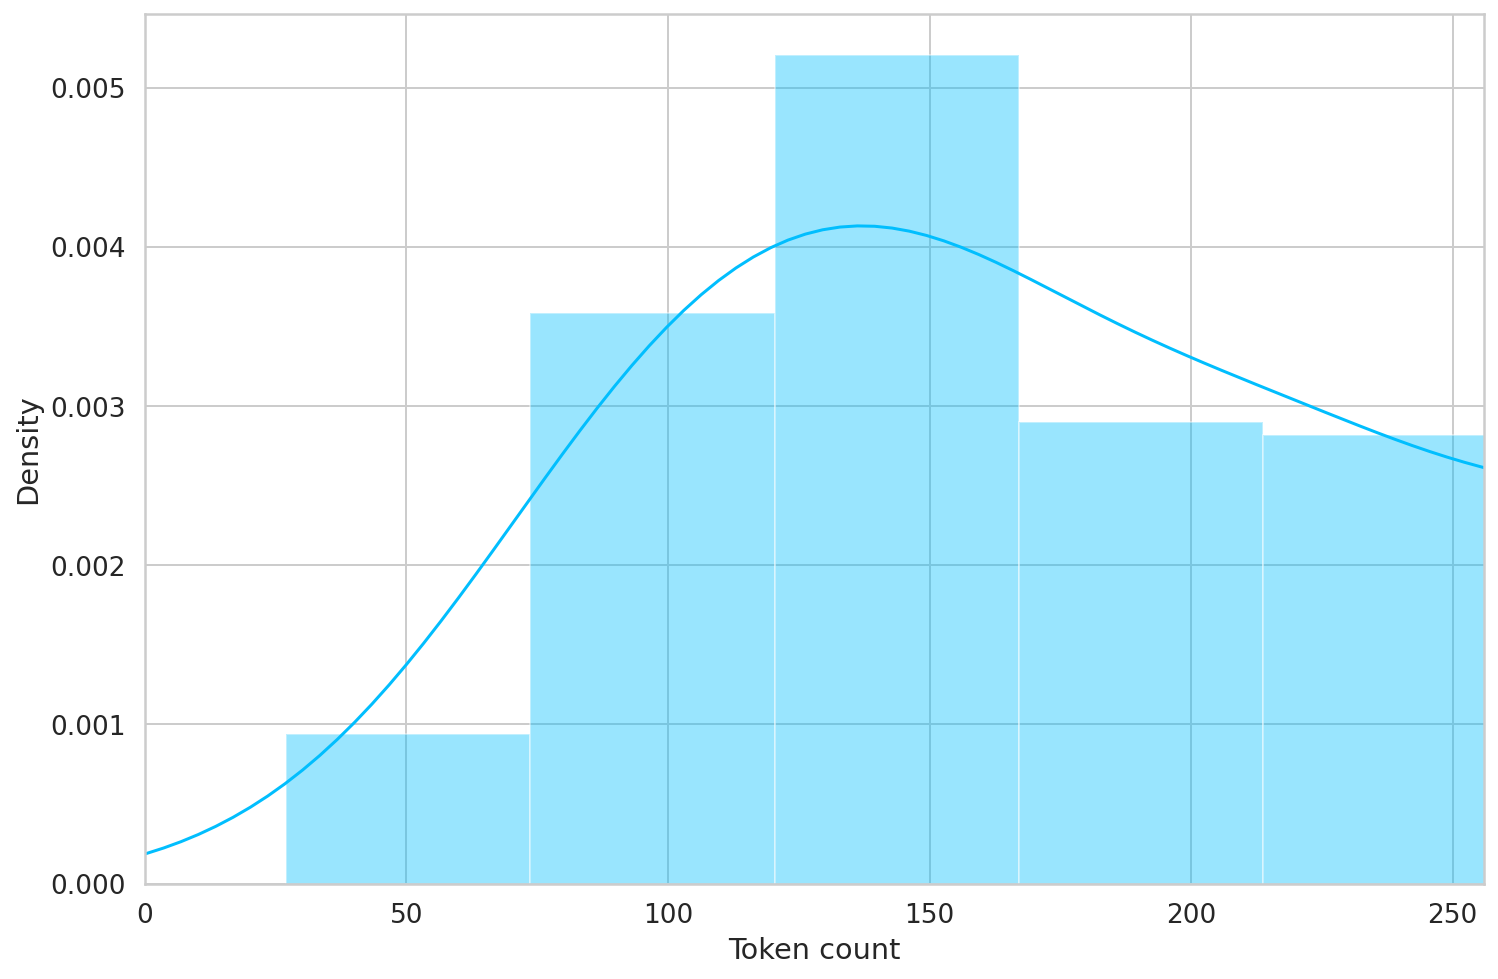

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [34]:
MAX_LEN = 500
BATCH_SIZE = 4
EPOCHS = 50

In [35]:
class GPReviewDataset(Dataset):

  def __init__(self, lyrics, targets, tokenizer, max_len):
    self.lyrics = lyrics
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.lyrics)
  
  def __getitem__(self, item):
    lyric = str(self.lyrics[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      lyric,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'lyrics_text': lyric,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [36]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [37]:
df_train.shape, df_val.shape, df_test.shape

((225, 6), (13, 6), (13, 6))

In [38]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    lyrics=df.lyrics.to_numpy(),
    targets=df.mood.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [67]:
BATCH_SIZE = 5

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [68]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['lyrics_text', 'input_ids', 'attention_mask', 'targets'])

In [69]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([5, 500])
torch.Size([5, 500])
torch.Size([5])


In [42]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [70]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [71]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [72]:

class MoodClassifier(nn.Module):

  def __init__(self, n_classes):
    super(MoodClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [73]:
model = MoodClassifier(len(class_names))
model = model.to(device)

In [74]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([5, 500])
torch.Size([5, 500])


In [75]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.1625, 0.1665, 0.1486, 0.2816, 0.2408],
        [0.1464, 0.1377, 0.1709, 0.3623, 0.1828],
        [0.1774, 0.2496, 0.1587, 0.2421, 0.1722],
        [0.1941, 0.2092, 0.1474, 0.2533, 0.1960],
        [0.1596, 0.1606, 0.1442, 0.3261, 0.2094]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [76]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [77]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [78]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [79]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.3532877723375956 accuracy 0.4177777777777778
Val   loss 1.221448540687561 accuracy 0.46153846153846156

Epoch 2/10
----------
Train loss 1.2144792881276874 accuracy 0.47555555555555556
Val   loss 1.6255487203598022 accuracy 0.0

Epoch 3/10
----------
Train loss 0.909034421046575 accuracy 0.6311111111111111
Val   loss 1.8816426992416382 accuracy 0.3076923076923077

Epoch 4/10
----------
Train loss 0.45736319890452753 accuracy 0.84
Val   loss 1.5066527128219604 accuracy 0.6153846153846154

Epoch 5/10
----------
Train loss 0.3382561284945243 accuracy 0.8711111111111111
Val   loss 2.1337796449661255 accuracy 0.5384615384615385

Epoch 6/10
----------
Train loss 0.08408494381647971 accuracy 0.9733333333333334
Val   loss 2.607030510902405 accuracy 0.5384615384615385

Epoch 7/10
----------
Train loss 0.006116218932179941 accuracy 1.0
Val   loss 3.840407689412435 accuracy 0.3076923076923077

Epoch 8/10
----------
Train loss 0.0034575817589130664 accuracy 1.0
V

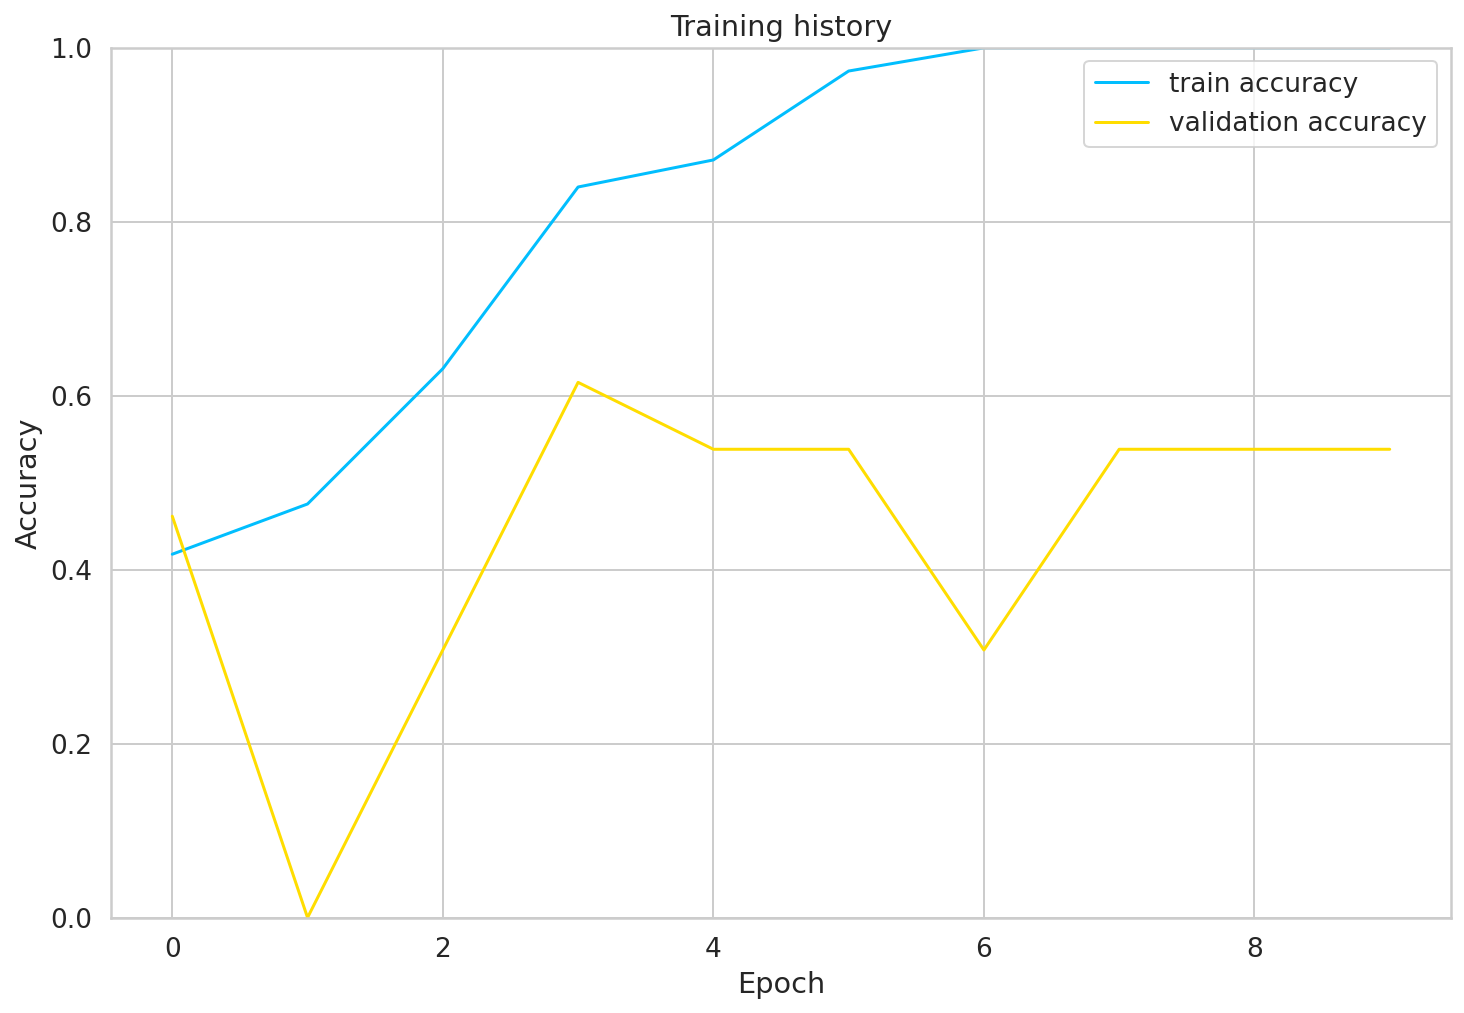

In [80]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [81]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.5384615384615385

In [82]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  lyrics_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["lyrics_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      lyrics_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return lyrics_texts, predictions, prediction_probs, real_values

In [83]:
y_lyrics_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [84]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       বেদনা       0.75      0.50      0.60         6
   দেশপ্রেম	       0.00      0.00      0.00         0
     ধার্মিক       0.00      0.00      0.00         0
       প্রেম       0.57      0.67      0.62         6
       আনন্দ       0.00      0.00      0.00         1

    accuracy                           0.54        13
   macro avg       0.26      0.23      0.24        13
weighted avg       0.61      0.54      0.56        13



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2486 missing from current font.
  font.set_text(s

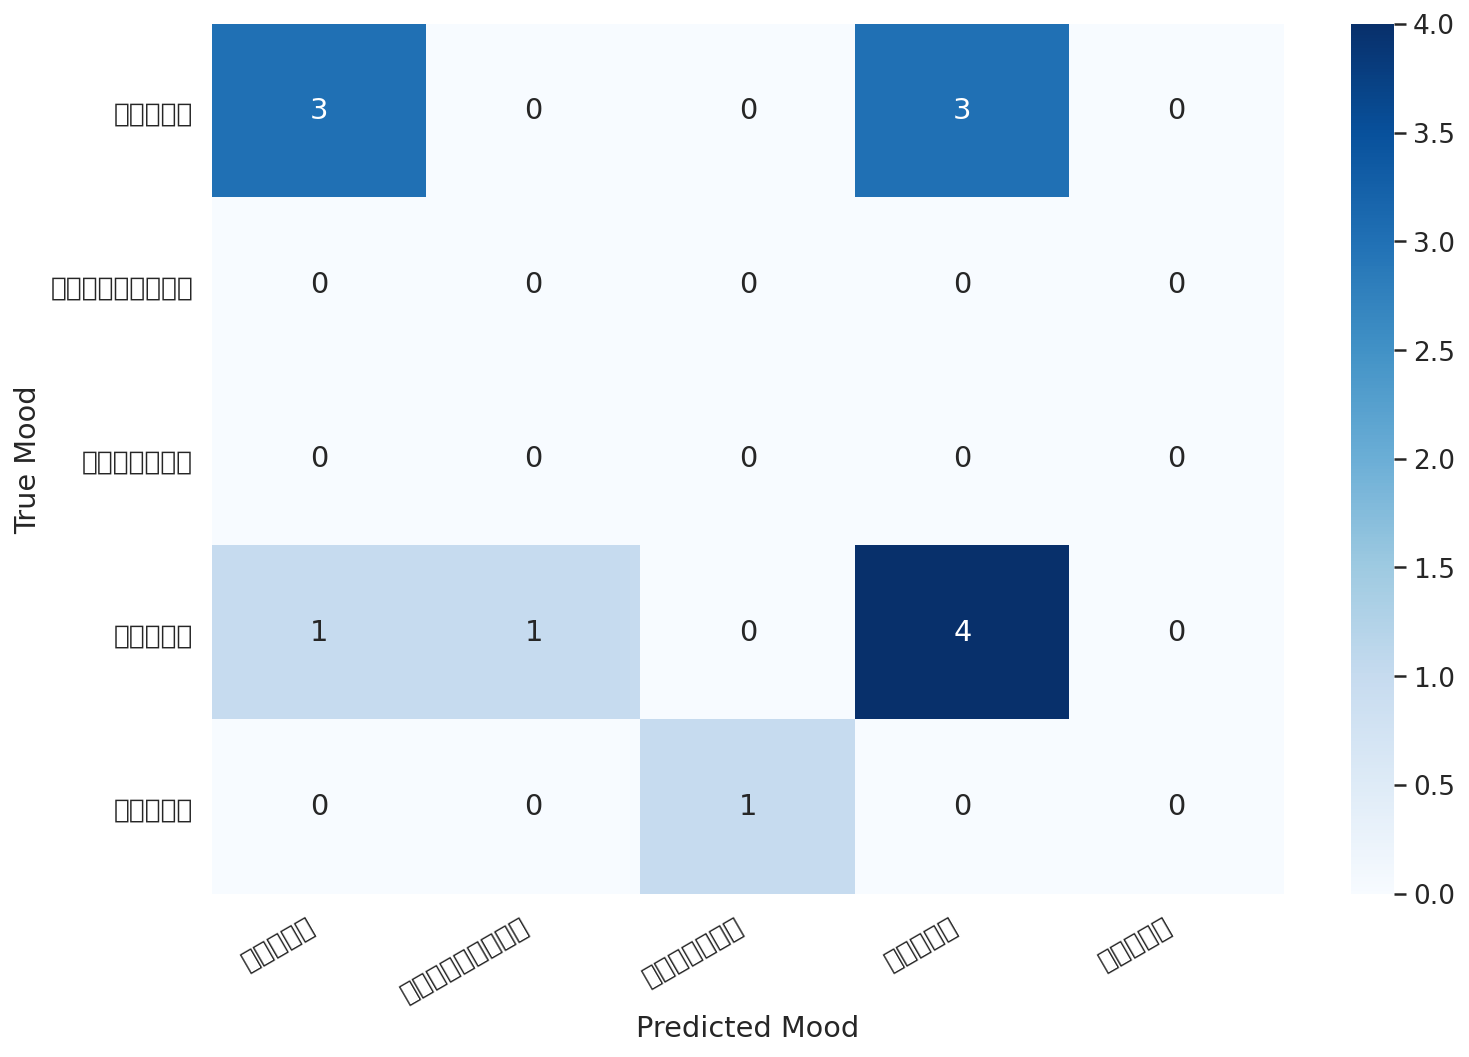

In [90]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Mood')
  plt.xlabel('Predicted Mood');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [91]:
idx = 2

lyric_text = y_lyrics_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [92]:
print("\n".join(wrap(lyric_text)))
print()
print(f'True Mood: {class_names[true_sentiment]}')

জল ভরো সুধরি কন্যা গো, আরে ও কন্যা জলে দিছো ঢেউ। হাঁসি মুখে কও না কথা,
সঙ্গে নাই মোর কেউ কন্যা গো। তুমি তো ভিনদেশী পুরুষ গো, ওরে ও সুজন আমি
ভিন্ন নারী। তোমার সাথে কইতে কথা, আম লজ্জায় মরি সুজন রে। কে বা তোমার
মাথা কন্যা গো, আরে ও কন্যা কে বা তোমার পিতা। এ দেশে আশিবার আগে তুমি
ছিলে কোথা কন্যা গো। নাহি আমার মাতা পিতা গো, আরে ও সুজন ঘরভো সদর ঘর।
স্রোতের শ্যাওলার মতো আমি, ভাইসা বেড়াই সুজন রে। মনের শুখে তুমি থাকো রে,
আরে ও সুজন সুন্দর নারী লইয়া, আপন হালে করছো ঘর, সুখেতে বান্দিয়া সুজন
রে। কন্যা তোমার সনে, আরে ও কন্যা বান্ধা হিয়া, মিছে কথা কইছো তুমি, না
কইরাছি বিয়া কন্যা গো। জল ভরো সুন্দরী কন্যা গো, আরে ও কন্যা জলে দিছো
ঢেউ।

True Mood: প্রেম


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2503 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2470 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2472 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2486 missing from current font.
  font.set_text(s

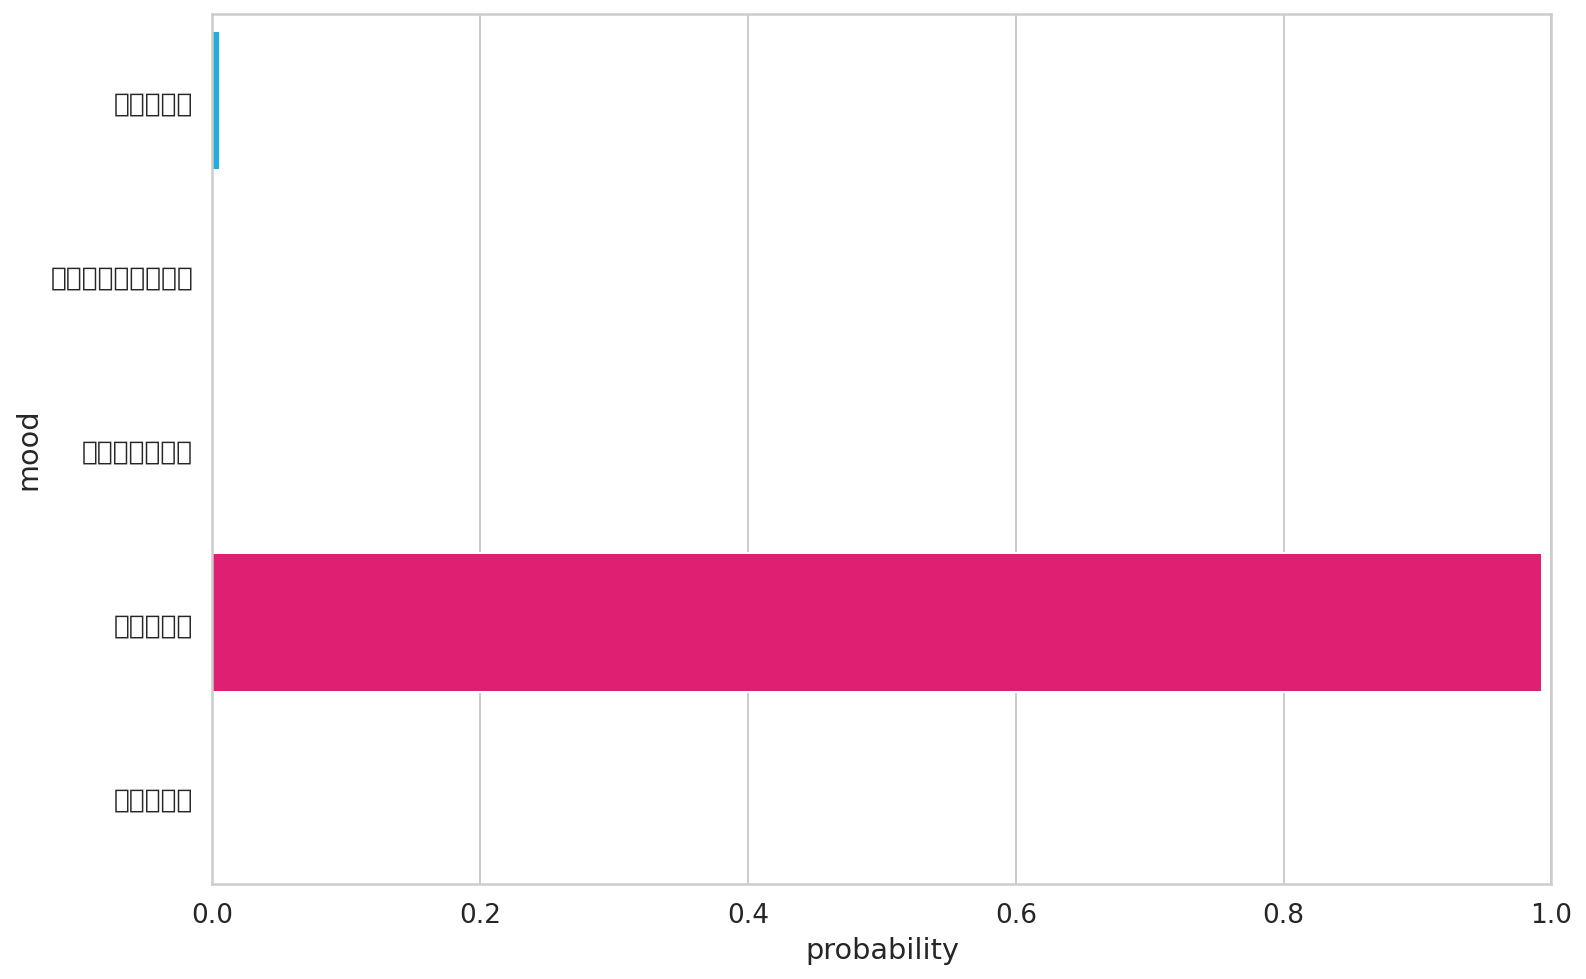

In [93]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('mood')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [98]:
lyric_text = "এই লভিনু সঙ্গ তব, সুন্দর হে সুন্দর !পুণ্য হল অঙ্গ মম, ধন্য হল অন্তর  সুন্দর হে সুন্দর॥ আলোকে মোর চক্ষুদুটি মুগ্ধ হয়ে উঠল ফুটি, হৃদ্‌গগনে পবন হল সৌরভেতে মন্থর   সুন্দর হে সুন্দর॥ এই তোমারি পরশরাগে চিত্ত হল রঞ্জিত, এই তোমারি মিলনসুধা রইল প্রাণে সঞ্চিত।  তোমার মাঝে এমনি ক’রে  নবীন করি লও যে মোরে এই জনমে ঘটালে মোর জন্ম-জনমান্তর   সুন্দর হে সুন্দর॥"

In [99]:
encoded_review = tokenizer.encode_plus(
  lyric_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [100]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'lyrics text: {lyric_text}')
print(f'mood  : {class_names[prediction]}')

lyrics text: এই লভিনু সঙ্গ তব, সুন্দর হে সুন্দর !পুণ্য হল অঙ্গ মম, ধন্য হল অন্তর  সুন্দর হে সুন্দর॥ আলোকে মোর চক্ষুদুটি মুগ্ধ হয়ে উঠল ফুটি, হৃদ্‌গগনে পবন হল সৌরভেতে মন্থর   সুন্দর হে সুন্দর॥ এই তোমারি পরশরাগে চিত্ত হল রঞ্জিত, এই তোমারি মিলনসুধা রইল প্রাণে সঞ্চিত।  তোমার মাঝে এমনি ক’রে  নবীন করি লও যে মোরে এই জনমে ঘটালে মোর জন্ম-জনমান্তর   সুন্দর হে সুন্দর॥
mood  : আনন্দ


In [101]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [104]:
model.save('/content/drive/MyDrive/Colab Notebooks/saved_model/testModel')

ModuleAttributeError: ignored